### Introduction

Every year thousands of students across India enroll in various programs in different colleges in the capital city of Delhi. A student before joining any college wants to make an informed choice and wishes to weigh his preference on the basis of concrete facts. When on one hand the rank of the college matters to him, other factors such as the cost of living in the vicinity of the college and the accessibility of services in and around the college is also a factor. Google search can help him explore colleges individually, but doing this for 90+ colleges and them comparing them altogether is a tedious task. Moreover the data which a student seeks to study is neither readily available nor clean enough or in the same metrics for all the college locations.
Therefore a comprehensive study of college location needs to be done.


### Aim

The aim is to cater to this problem by using data as a tool for detailed study & analysis. This is done by :
1. Scrapping list of colleges
2. Getting the price of localities in Delhi
3. Mapping the colleges with localities using geo cordinates
4. Ananlyzing each college neighborhood
5. Clustering colleges and drawing concusiond from each clusters

### Dataset

1. The list of colleges under Delhi University was scrapped from their official website:
 www.du.ac.in/du/index.php?page=list-of-colleges.
2. The rental prices for various localities was scrapped from the website - 
https://www.makaan.com/price-trends/property-rates-for-rent-in-delhi
3. The coordinates of college as well as localities of Delhi was retrieved using Nominatim geocoder. Since this package couldn’t find coordinates for each and every college,the leftover entries were typed in manually.
4. The FourSquare api was used thereafter to get the nearby venue details.


In [2]:
import urllib.request
#import time
from bs4 import BeautifulSoup #library for web scraping
from lxml import html
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import json library to handle JSON files
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
from sklearn.preprocessing import StandardScaler
#!pip install folium
import folium
print('Libraries imported.')

Libraries imported.


In [3]:
import warnings
warnings. filterwarnings("ignore")

### 1. Scrapping list of colleges in Delhi

In [4]:
response = requests.get('http://du.ac.in/du/index.php?page=list-of-colleges')
soup = BeautifulSoup(response.text, 'html.parser')
data = soup.find(class_='content-inner grid_9 push_3')
data1 = data.find_all('a')
college=[]

for x in data1:
    names = x.contents[0]
    college.append(names)
df=pd.DataFrame(college, columns =['College Name'])
df=df.reindex(columns=[*df.columns.tolist(), 'Latitude', 'Longitude',])
df.head()

,College Name,Latitude,Longitude
0,Acharya Narendra Dev College,NaN,NaN
1,Aditi Mahavidyalaya,NaN,NaN
2,Ahilya Bai College of Nursing,NaN,NaN
3,Amar Jyoti Institute of Physiotherapy,NaN,NaN
4,Aryabhatta College(Formally Ram Lal Anand Coll...,NaN,NaN


**Cleaning the Data**

Removing evening college as they are duplicate in the list.

In [5]:
df.drop(df[df['College Name'].str.endswith('(Evening)')].index, inplace=True)
#df.reset_index(inplace=True)
df.shape
# List of medical college: http://www.studyguideindia.com/Colleges/Medical/default.asp?College_type=JNKQEMC8&hdninttype=JNKQEMC8&State=DL&sort=&by=&page=JNKPNQL0 

(84, 3)

### 2. Scrapping geospatial Rental pricing Data

In [6]:
def scrap_pricing(url):

  opener = urllib.request.build_opener()
  opener.addheaders = [('User-agent', 'Mozilla/5.0')]
  response = opener.open(url)
  dff = pd.read_html(response.read())[0]
  dff.columns = dff.columns.droplevel() #dropping topmost column row from the table
  dff.columns = ['_'.join(col) for col in dff.columns]
  dff.rename(columns={ dff.columns[0]: "Locality" }, inplace = True)
  return dff

In [7]:
df1 = pd.DataFrame() #dataframe for storing pricing values from all pages combined

Using a loop to scrap pricing data from 20 pages of makaan.com

In [8]:
for i in range(1,21):
  url= 'https://www.makaan.com/price-trends/property-rates-for-rent-in-delhi?page='+str(i)
  df1 = pd.concat([df1,scrap_pricing(url)])
df1.reset_index(inplace=True,drop=True)
df1.head()

,Locality,1 BHk_Rent range,1 BHk_Avg rent,2 BHK_Rent range,2 BHK_Avg rent,3 BHK_Rent range,3 BHK_Avg rent
0,Uttam Nagar,11000,11000,"10,000 - 15,000",10900,15000,15000
1,Dwarka Mor,"5,500 - 10,000",7249.75,"5,000 - 11,000",8166.67,"10,000 - 30,000",17285.7
2,Chattarpur,"5,000 - 20,000",9404.92,"9,000 - 28,000",15656.58,"13,000 - 28,000",20693.5
3,Vasant Kunj,"10,000 - 14,500",12166.67,"20,000 - 38,000",26800,60000,60000
4,Greater kailash 1,"14,000 - 1 L",34905.66,"18,500 - 85,000",53401.52,"65,000 - 1 L",82500


**Cleaning the Data**

In [9]:
#droping extra rows that contain pricing range
df1.drop(columns = ['1 BHk_Rent range','2 BHK_Rent range','3 BHK_Rent range'],inplace=True)
# converting string values to float values
df1['1 BHk_Avg rent']=pd.to_numeric(df1['1 BHk_Avg rent'], errors='coerce')
df1['2 BHK_Avg rent']=pd.to_numeric(df1['2 BHK_Avg rent'], errors='coerce')
df1['3 BHK_Avg rent']=pd.to_numeric(df1['3 BHK_Avg rent'], errors='coerce')

Merging rows to get 1 BHK rent price and droping the empty rows

In [10]:
for index, row in df1.iterrows():
    if np.isnan(row['1 BHk_Avg rent']):
      if np.isnan(row['2 BHK_Avg rent']):
        if np.isnan(row['3 BHK_Avg rent']):
          df1.drop(index, inplace=True)
        else:
          df1.at[index,'1 BHk_Avg rent']=(row['3 BHK_Avg rent'])/3
      else:
        df1.at[index,'1 BHk_Avg rent']=(row['2 BHK_Avg rent'])/2

In [11]:
df1.drop(columns=['2 BHK_Avg rent','3 BHK_Avg rent'],inplace=True)
df1.reset_index(drop=True,inplace=True)
df1 = df1.sort_values('1 BHk_Avg rent')
print(df1.shape)
df1.head()

(718, 2)


,Locality,1 BHk_Avg rent
390,Okhla Phase I,971.43
243,Jasola Vihar Sector 8 Road,1385.71
40,Sainik Farms,1410.87
320,Sadulajab,1741.67
123,Ashok Nagar,1745.45


### 3. Getting Latitude and Longitude of colleges

In [13]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Test Agent1")

In [14]:
for index,row in df.iterrows():
  location = geolocator.geocode(row['College Name']+', Delhi, India')
  if location:
    df.at[index,'Latitude'] = location.latitude
    df.at[index,'Longitude'] = location.longitude

**Cleaning the data: removing colleges without coordinates**

In [15]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.tail()

,College Name,Latitude,Longitude
42,Vivekananda College,28.564790,77.180626
43,Zakir Husain Delhi College,28.605530,77.234618
44,National Institute of Health & Family Welfare,28.550339,77.174617
45,Kasturba Hospital,28.649261,77.237300
46,Institute of Human Behaviour & Allied Sciences,28.681118,77.305023


Nominatim package could only found coordinates of half of the colleges. Other alternate is to use the google geocode api, but that requires billing.
Therefore adding coordinates of colleges manually.

In [ ]:
#df.to_excel('ducoordinates.xlsx',index=false)

In [16]:
url = 'https://github.com/saransh-bajpai/neighborhood-segementation/blob/master/data/ducoordinates.xlsx?raw=true'
df=pd.read_excel(url)

In [17]:
df.tail()

,College Name,Latitude,Longitude
72,Zakir Husain Delhi College,28.605530,77.234618
73,National Institute of Health & Family Welfare,28.550339,77.174617
74,Kasturba Hospital,28.649261,77.237300
75,Institute of Human Behaviour & Allied Sciences,28.681118,77.305023
76,All India Institute of Ayurveda,28.514499,77.299043


### 4. Getting Coordinates of Localities in Delhi

In [18]:
df1=df1.reindex(columns=[*df1.columns.tolist(), 'Latitude', 'Longitude'])
df1.tail()

,Locality,1 BHk_Avg rent,Latitude,Longitude
532,G Block H Block Road Saket,162222.223333,NaN,NaN
530,Diplomatic Enclave,175000.000000,NaN,NaN
257,Chanakya Puri,175000.000000,NaN,NaN
488,Tilak Marg,200000.000000,NaN,NaN
122,C R Park,200000.000000,NaN,NaN


Using geolocator to get the coordinates of various localities within Delhi

In [19]:
geolocator = Nominatim(user_agent="my-application1")
for index,row in df1.iterrows():
  location = geolocator.geocode(row['Locality']+', Delhi, India')
  if location:
    df1.at[index,'Latitude'] = location.latitude
    df1.at[index,'Longitude'] = location.longitude

In [20]:
df1.tail()

,Locality,1 BHk_Avg rent,Latitude,Longitude
532,G Block H Block Road Saket,162222.223333,NaN,NaN
530,Diplomatic Enclave,175000.000000,NaN,NaN
257,Chanakya Puri,175000.000000,28.613896,77.207592
488,Tilak Marg,200000.000000,28.620112,77.236624
122,C R Park,200000.000000,28.480863,77.084888


Cleaning the Data

In [21]:
df1.dropna(inplace=True)
df1.reset_index(drop=True,inplace=True)
print(df1.shape)
df1.head()

(536, 4)


,Locality,1 BHk_Avg rent,Latitude,Longitude
0,Okhla Phase I,971.43,28.527341,77.279433
1,Ashok Nagar,1745.45,28.636021,77.101822
2,Jaitpur,3000.00,28.500477,77.316192
3,Karawal Nagar,3000.00,28.731141,77.274790
4,Dharampura,3000.00,28.608664,76.990166


### 5. Merging College Name with Locality and average rental pricing 

In [22]:
from geopy.distance import geodesic
df=df.reindex(columns=[*df.columns.tolist(), '1 BHK_Avg Rent',],fill_value=0)

In [23]:
for index,row in df.iterrows():
  cordi1 = (row['Latitude'],row['Longitude'])
  for index2,row2 in df1.iterrows():
    cordi2 = (row2['Latitude'],row2['Longitude'])
    dis = geodesic(cordi1, cordi2)
    if(dis<1.5):
      #print(dis)
      df.at[index,'1 BHK_Avg Rent'] = row2['1 BHk_Avg rent']
      break

In [24]:
df.head()

,College Name,Latitude,Longitude,1 BHK_Avg Rent
0,Acharya Narendra Dev College,28.538862,77.264228,5000
1,Aditi Mahavidyalaya,28.794083,77.037506,5000
2,Ahilya Bai College of Nursing,28.638169,77.237829,12000
3,Amar Jyoti Institute of Physiotherapy,28.649646,77.301328,6000
4,Aryabhatta College(Formally Ram Lal Anand Coll...,28.578051,77.161460,4000


###5. Exploratory Data Analysis

####Locality and average Rent

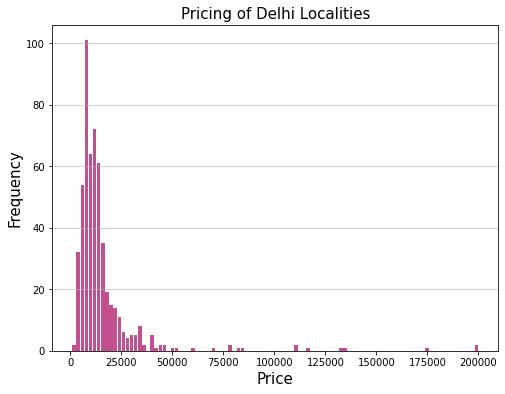

In [25]:
plt.figure(figsize=[8,6])
n, bins, patches = plt.hist(x=df1['1 BHk_Avg rent'], bins='auto', color='#aa045f',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Pricing of Delhi Localities',fontsize=15)
plt.show()

The locality average pricing data scraped from makaan.com contains many outliers in high range values. These prices are of the expensive housing which aren't availed by students and is therefore need to be removed from our analysis.

####Colleges and Avg Rent

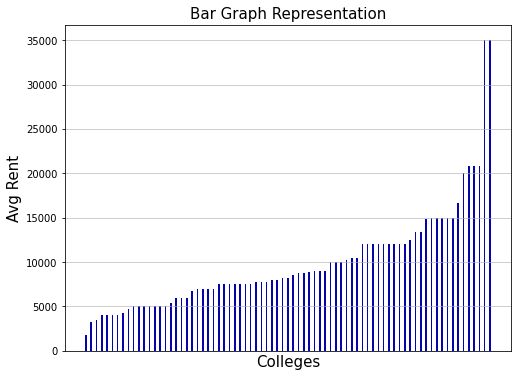

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=[8,6])
dfp = df.sort_values('1 BHK_Avg Rent')
plt.bar(dfp['College Name'], dfp['1 BHK_Avg Rent'], width=.3,color='#0504aa')
plt.xticks([])
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Colleges',fontsize=15)
plt.ylabel('Avg Rent',fontsize=15)
plt.title('Bar Graph Representation',fontsize=15)
plt.show()

The average rent of places is mostly between 5000-20,000 thousand with outliers as high as 35000.

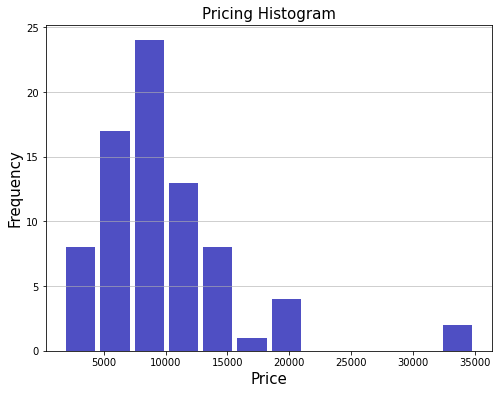

In [27]:
plt.figure(figsize=[8,6])
n, bins, patches = plt.hist(x=dfp['1 BHK_Avg Rent'], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Pricing Histogram',fontsize=15)
plt.show()

Maximum neighborhoods have a rent of 8000-10000, with other other neighborhoods in range of either 5000 or 10,000-20,000

####Colleges Zone Wise : 

The capital city of Delhi is divided into the various zones. Lets see the distribution of various colleges in various zones of the city.

In [28]:
url = 'https://github.com/saransh-bajpai/neighborhood-segementation/blob/master/data/zones_coordinates.xlsx?raw=true'
dz=pd.read_excel(url)

In [29]:
df_zones = df
df_zones['zone']=""

In [30]:
for index,row in df_zones.iterrows():
  min =100
  cordi1 = (row['Latitude'],row['Longitude'])
  for index2,row2 in dz.iterrows():
    cordi2 = (row2['Latitude'],row2['Longitude'])
    dis = geodesic(cordi1, cordi2)
    if (dis<min):
      min=dis
      x = row2
    df_zones.at[index,'zone'] = x['District']

In [31]:
df_zones.head()

,College Name,Latitude,Longitude,1 BHK_Avg Rent,zone
0,Acharya Narendra Dev College,28.538862,77.264228,5000,South East Delhi
1,Aditi Mahavidyalaya,28.794083,77.037506,5000,North West Delhi
2,Ahilya Bai College of Nursing,28.638169,77.237829,12000,Central Delhi
3,Amar Jyoti Institute of Physiotherapy,28.649646,77.301328,6000,East Delhi
4,Aryabhatta College(Formally Ram Lal Anand Coll...,28.578051,77.161460,4000,New Delhi


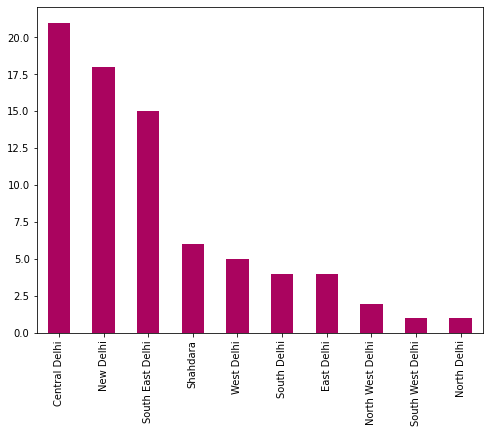

In [32]:
df_zones['zone'].value_counts().plot(kind ='bar',figsize=[8,6],color='#aa045f')

Most of the colleges are in Central,New or South East Delhi region. West,South,East Delhi have mediocre number of colleges while North West,South West and North Delhi have the least number of College campus

### 6. Finding top venues around the colleges

Define Foursquare Credentials and Version

In [120]:
CLIENT_ID = 'XR4LQIF032CN5JAEWEUE5A0CRHUVB2V3PVYRKHNSAOSXLD2I' # your Foursquare ID
CLIENT_SECRET = 'YKZ4HHSEI0K25BKUUSTU4JENIFNPOFL0VZ0C5AW40Z1BE4GK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XR4LQIF032CN5JAEWEUE5A0CRHUVB2V3PVYRKHNSAOSXLD2I
CLIENT_SECRET:YKZ4HHSEI0K25BKUUSTU4JENIFNPOFL0VZ0C5AW40Z1BE4GK


In [121]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Function to get venue details for all the colleges

In [122]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT =100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['College Name',            
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Code to run the above function on each college and creating a new dataframe called *college_venues*.

In [123]:
college_venues = getNearbyVenues(names=df['College Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Acharya Narendra Dev College
Aditi Mahavidyalaya
Ahilya Bai College of Nursing
Amar Jyoti Institute of Physiotherapy
Aryabhatta College(Formally Ram Lal Anand College-Evg.)
Atma Ram Sanatan Dharma College
Ayurvedic & Unani Tibia College
Bharati College
Bhaskaracharya College of Applied Sciences
Bhim Rao Ambedkar College
Chacha Nehru Bal Chikitsalaya
College of Nursing at Army Hospital (R&R)
College of Vocational Studies
Daulat Ram College
Deen Dayal Upadhyaya College
Delhi Institute of Pharmaceutical Sciences and Research
Deshbandhu College(Morning)
Durga Bai Deshmukh College of Special Edu.(VI)
Dyal Singh College
Florence Nightingale College of Nursing
Gargi College
Hans Raj College
Hindu College
Holy Family College of Nursing
Indira Gandhi Institute of Physical Education & Sports Sciences
Indraprastha College for Women
Institute of Home Economics
Janki Devi Memorial College
Kalindi College for Women
Kamla Nehru College for Women
Keshav Mahavidyalaya
Kirori Mal College
Lady Hardinge M

Let's check the size of the resulting dataframe

In [124]:
print(college_venues.shape)
college_venues.head()

(485, 7)


,College Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acharya Narendra Dev College,28.538862,77.264228,D-Conido,28.537225,77.265736,Pet Store
1,Acharya Narendra Dev College,28.538862,77.264228,Kalkaji Sabji Mandi,28.539024,77.261318,Farmers Market
2,Aditi Mahavidyalaya,28.794083,77.037506,My Idea Store,28.795090,77.033469,Mobile Phone Shop
3,Ahilya Bai College of Nursing,28.638169,77.237829,Hotel Broadway New Delhi,28.641058,77.237908,Hotel
4,Ahilya Bai College of Nursing,28.638169,77.237829,Feroz Shah Kotla Stadium | फिरोज शाह कोटला स्ट...,28.637907,77.241869,Cricket Ground


Venue Categories count:

In [ ]:
college_venues['Venue Category'].value_counts()

### 7. Analyze Each College neighborhood

---



In [125]:
#one hot encoding
college_onehot = pd.get_dummies(college_venues[['Venue Category']], prefix="", prefix_sep="")
#del college_onehot['College Name']

#add College Name column back to dataframe at the start
college_onehot.insert(0, 'College Name', (college_venues['College Name']) )
college_onehot.head()

,College Name,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Boutique,Breakfast Spot,Building,Burger Joint,Bus Station,Business Center,Cafeteria,Café,Camera Store,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Light Rail Station,Lounge,Market,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Mosque,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Noodle House,North Indian Restaurant,Other Great Outdoors,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Souvenir Shop,Spa,Stadium,Tea Room,Temple,Thai Restaurant,Theater,Theme Park,Trail,Train Station,Udupi Restaurant,University,Whisky Bar,Women's Store,Yoga Studio
0,Acharya Narendra Dev College,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acharya Narendra Dev College,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Aditi Mahavidyalaya,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ahilya Bai College of Nursing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ahilya Bai College of Nursing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [126]:
college_onehot.shape

(485, 120)

Next, let's group rows by College Name and by taking the mean of the frequency of occurrence of each category

In [127]:
college_grouped = college_onehot.groupby('College Name').mean().reset_index()
print(college_grouped.shape)
college_grouped.head()

(71, 120)


,College Name,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Boutique,Breakfast Spot,Building,Burger Joint,Bus Station,Business Center,Cafeteria,Café,Camera Store,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Light Rail Station,Lounge,Market,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Mosque,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Noodle House,North Indian Restaurant,Other Great Outdoors,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Souvenir Shop,Spa,Stadium,Tea Room,Temple,Thai Restaurant,Theater,Theme Park,Trail,Train Station,Udupi Restaurant,University,Whisky Bar,Women's Store,Yoga Studio
0,Acharya Narendra Dev College,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,Aditi Mahavidyalaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,Ahilya Bai College of Nursing,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,All India Institute of Ayurveda,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,Amar Jyoti Institute of Physiotherapy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Add Rent Price column to the dataframe

In [128]:
college_grouped = pd.merge(df, college_grouped, on=['College Name'], how='inner')
college_grouped.head()

,College Name,Latitude,Longitude,1 BHK_Avg Rent,zone,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Bengali Restaurant,Bistro,Boutique,Breakfast Spot,Building,Burger Joint,Bus Station,Business Center,Cafeteria,Café,Camera Store,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Light Rail Station,Lounge,Market,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Mosque,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Noodle House,North Indian Restaurant,Other Great Outdoors,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Restaurant,Salad Place,Sandwich Place,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Souvenir Shop,Spa,Stadium,Tea Room,Temple,Thai Restaurant,Theater,Theme Park,Trail,Train Station,Udupi Restaurant,University,Whisky Bar,Women's Store,Yoga Studio
0,Acharya Narendra Dev College,28.538862,77.264228,5000,South East Delhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,Aditi Mahavidyalaya,28.794083,77.037506,5000,North West Delhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,Ahilya Bai College of Nursing,28.638169,77.237829,12000,Central Delhi,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,Amar Jyoti Institute of Physiotherapy,28.649646,77.301328,6000,East Delhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
4,Aryabhatta College(Formally Ram Lal Anand Coll...,28.578051,77.161460,4000,New Delhi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

College Name along with the top most common venues(Maximum 5)

In [ ]:
max_num_top_venues = 5

for hood in college_grouped['College Name']:
    print("----"+hood+"----")
    temp = college_grouped[college_grouped['College Name'] == hood].T.reset_index() # getting respective rows of College Name
    temp.columns = ['venue','freq'] # define new columns
    temp = temp.iloc[5:] #moving to venue column
    temp['freq'] = temp['freq'].astype(float) # data formating
    temp = temp.round({'freq': 2})
    temp = temp[temp['freq']>0.0]
    temp.sort_values('freq', ascending=False,inplace=True)
    temp.reset_index(drop=True,inplace=True)
    print(temp.head(max_num_top_venues))
    print('\n')

Let's put that into a *pandas* dataframe

Function to find number of venues

In [130]:
def venue_number(row):
   row =row.iloc[5:]
   row =row[row!=0]
   return row.shape[0]+1

Function to sort the venues in descending order.

In [131]:
def return_most_common_venues(row, num_top_venues):
  
  row_categories = row.iloc[5:]
  row_categories = row_categories[row_categories !=0]
  row_categories_sorted = row_categories.sort_values(ascending=False)
  return(row_categories_sorted.index.values[0:num_top_venues])

Now let's create the new dataframe and display the top 10 venues for each College Name.

In [132]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['College Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
college_venues_sorted = pd.DataFrame(columns=columns)

college_venues_sorted['College Name'] = college_grouped['College Name']

for ind in np.arange(college_grouped.shape[0]):
    x = venue_number(college_grouped.iloc[ind, :])
    college_venues_sorted.iloc[ind, 1: min(x,11)] = return_most_common_venues(college_grouped.iloc[ind, :], min(x,10))

college_venues_sorted.head()

,College Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharya Narendra Dev College,Pet Store,Farmers Market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aditi Mahavidyalaya,Mobile Phone Shop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ahilya Bai College of Nursing,Indian Restaurant,Hotel,Hostel,Soccer Stadium,Movie Theater,Cricket Ground,Asian Restaurant,NaN,NaN,NaN
3,Amar Jyoti Institute of Physiotherapy,Train Station,Light Rail Station,Gym,Food Truck,NaN,NaN,NaN,NaN,NaN,NaN
4,Aryabhatta College(Formally Ram Lal Anand Coll...,Hotel,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here NaN represent that the venues found by foursqaure api was limited uptill mentioned venue name only.

### 8. Cluster Colleges

In [145]:
college_grouped_clustering = college_grouped.drop(['College Name','Latitude','Longitude','zone'], 1)
print(college_grouped_clustering.shape)

(71, 120)


Standardizing Data

In [134]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(college_grouped_clustering)
data_scaled = mms.transform(college_grouped_clustering)

In [135]:
data_scaled

array([[0.09788002, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09788002, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30837468, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.17305668, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18057435, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06780935, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Elbow method for optimum k**

In [ ]:
'''
sum_squared_distance=[]

for k in range(1,10):
    kmeans=KMeans(n_clusters=k).fit(data_scaled)
    kmeans.predict(data_scaled)
    sum_squared_distance.append(kmeans.inertia_)

#Let's plot the graph now to find the optimal 'k'

plt.plot(range(1,10),sum_squared_distance,'bx-')
plt.title("Elbow method for KMeans")
plt.xlabel("K Value")
plt.ylabel("Inertia")
plt.show()
'''

Run *k*-means to cluster the neighborhood into 4 clusters.

In [146]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(college_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 0, 1, 1, 2, 1, 3, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
      dtype=int32)

In [148]:
#del college_venues_sorted['Cluster Labels']

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [149]:
# add clustering labels
college_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

college_merged = pd.merge(df, college_venues_sorted, on=['College Name'], how='inner')
college_merged.head() 

,College Name,Latitude,Longitude,1 BHK_Avg Rent,zone,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharya Narendra Dev College,28.538862,77.264228,5000,South East Delhi,1,Pet Store,Farmers Market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aditi Mahavidyalaya,28.794083,77.037506,5000,North West Delhi,1,Mobile Phone Shop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ahilya Bai College of Nursing,28.638169,77.237829,12000,Central Delhi,0,Indian Restaurant,Hotel,Hostel,Soccer Stadium,Movie Theater,Cricket Ground,Asian Restaurant,NaN,NaN,NaN
3,Amar Jyoti Institute of Physiotherapy,28.649646,77.301328,6000,East Delhi,1,Train Station,Light Rail Station,Gym,Food Truck,NaN,NaN,NaN,NaN,NaN,NaN
4,Aryabhatta College(Formally Ram Lal Anand Coll...,28.578051,77.161460,4000,New Delhi,1,Hotel,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, let's visualize the resulting clusters

In [150]:
# create map
map_clusters = folium.Map(location=[28.6304	, 77.2177], zoom_start=11)

# set color scheme for the clusters
rainbow = ['#9500ff', '#fffb00', '#149945', '#ff0000']

# add markers to the map
markers_colors = []
for lat, lon, name, cluster, price in zip(college_merged['Latitude'], college_merged['Longitude'], college_merged['College Name'], college_merged['Cluster Labels'],college_merged['1 BHK_Avg Rent']):
  label = folium.Popup(name + ', Avg Rent:' + str(price), parse_html=True)
  folium.CircleMarker(
      [lat, lon],
      radius=5,
      popup=label,
      color=rainbow[cluster-1],
      fill=True,
      fill_color=rainbow[cluster-1],
      fill_opacity=1).add_to(map_clusters)
       
map_clusters

### 9. Examine Clusters

#### Cluster 1

In [159]:
college_merged.loc[college_merged['Cluster Labels'] == 0, college_merged.columns[[0]+[3]+[4] + list(range(6, college_merged.shape[1]))]]

,College Name,1 BHK_Avg Rent,zone,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ahilya Bai College of Nursing,12000,Central Delhi,Indian Restaurant,Hotel,Hostel,Soccer Stadium,Movie Theater,Cricket Ground,Asian Restaurant,NaN,NaN,NaN
9,Chacha Nehru Bal Chikitsalaya,10000,East Delhi,Mobile Phone Shop,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,College of Nursing at Army Hospital (R&R),10000,New Delhi,Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Daulat Ram College,12083,Central Delhi,Tea Room,Restaurant,Pet Store,Miscellaneous Shop,Cheese Shop,NaN,NaN,NaN,NaN,NaN
16,Durga Bai Deshmukh College of Special Edu.(VI),10500,New Delhi,Restaurant,Indian Restaurant,Hotel,Chinese Restaurant,Spa,Pizza Place,Italian Restaurant,Hotel Bar,Design Studio,Convenience Store
17,Dyal Singh College,10500,New Delhi,Theater,Temple,Pedestrian Plaza,Light Rail Station,NaN,NaN,NaN,NaN,NaN,NaN
20,Hindu College,15000,Central Delhi,Fried Chicken Joint,Café,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Indraprastha College for Women,15000,Central Delhi,Smoke Shop,Light Rail Station,Italian Restaurant,Indian Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Burger Joint,Asian Restaurant,NaN
26,Kalindi College for Women,12000,Central Delhi,Multicuisine Indian Restaurant,Indian Restaurant,Fast Food Restaurant,Arcade,NaN,NaN,NaN,NaN,NaN,NaN
29,Kirori Mal College,12083,Central Delhi,Fast Food Restaurant,Pizza Place,Donut Shop,Coffee Shop,Chinese Restaurant,Snack Place,Sandwich Place,Parking,Miscellaneous Shop,Juice Bar


This cluster contains colleges  of particularly **Central Delhi zone** which have a **mediocre** living expense. The neighborhood of such college consists places like *restaurants,hostels and parks.*

#### Cluster 2

In [158]:
college_merged.loc[college_merged['Cluster Labels'] == 1, college_merged.columns[[0]+[3]+[4] + list(range(5, college_merged.shape[1]))]]

,College Name,1 BHK_Avg Rent,zone,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharya Narendra Dev College,5000,South East Delhi,1,Pet Store,Farmers Market,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aditi Mahavidyalaya,5000,North West Delhi,1,Mobile Phone Shop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amar Jyoti Institute of Physiotherapy,6000,East Delhi,1,Train Station,Light Rail Station,Gym,Food Truck,NaN,NaN,NaN,NaN,NaN,NaN
4,Aryabhatta College(Formally Ram Lal Anand Coll...,4000,New Delhi,1,Hotel,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Ayurvedic & Unani Tibia College,7000,Central Delhi,1,Pizza Place,Department Store,Coffee Shop,Asian Restaurant,NaN,NaN,NaN,NaN,NaN,NaN
8,Bhaskaracharya College of Applied Sciences,4300,South West Delhi,1,Bus Station,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,College of Vocational Studies,7000,South East Delhi,1,Trail,Pizza Place,Fast Food Restaurant,Clothing Store,NaN,NaN,NaN,NaN,NaN,NaN
13,Deen Dayal Upadhyaya College,1745,West Delhi,1,Restaurant,Other Great Outdoors,Hotel,Arcade,NaN,NaN,NaN,NaN,NaN,NaN
14,Delhi Institute of Pharmaceutical Sciences and...,5333,South Delhi,1,Park,Mobile Phone Shop,Café,Boutique,Asian Restaurant,NaN,NaN,NaN,NaN,NaN
15,Deshbandhu College(Morning),5000,South East Delhi,1,Market,Fast Food Restaurant,Sandwich Place,Pizza Place,Indian Restaurant,Coffee Shop,NaN,NaN,NaN,NaN


This cluster contains colleges of mostly **all zones** which have a **least** living expense. The neighborhood of such college consists of places like *department stores and shops for all needs.*

####Cluster 3

In [157]:
college_merged.loc[college_merged['Cluster Labels'] == 2, college_merged.columns[[0]+[3]+[4] + list(range(5, college_merged.shape[1]))]]

,College Name,1 BHK_Avg Rent,zone,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Atma Ram Sanatan Dharma College,35000,New Delhi,2,Café,Snack Place,Plaza,Deli / Bodega,Bistro,NaN,NaN,NaN,NaN,NaN
62,Sri Venkateswara College,35000,New Delhi,2,Café,Snack Place,Plaza,Deli / Bodega,Bistro,NaN,NaN,NaN,NaN,NaN


This cluster contains colleges  of **New Delhi zone** which have a **very high** living expense. The neighborhood of such college consists places like *cafes, plaza and bistro.*

####Cluster 4

In [156]:
college_merged.loc[college_merged['Cluster Labels'] == 3, college_merged.columns[[0]+[3]+[4]+ list(range(5, college_merged.shape[1]))]]

,College Name,1 BHK_Avg Rent,zone,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bharati College,20000,New Delhi,3,Theater,Indian Restaurant,Café,Bakery,Art Gallery,Light Rail Station,Hotel Bar,Concert Hall,Arcade,NaN
31,Lady Irwin College,20833,New Delhi,3,Theater,Train Station,Plaza,Light Rail Station,Hotel,Café,Art Gallery,Arcade,NaN,NaN
32,Lady Shri Ram College for Women,20833,New Delhi,3,Theater,Indian Restaurant,Café,Bakery,Hotel,Art Gallery,Arcade,NaN,NaN,NaN
43,Pt. Deendayal Upadhyaya Institute of Physicall...,20833,New Delhi,3,Udupi Restaurant,Plaza,Performing Arts Venue,Fast Food Restaurant,Café,Art Museum,NaN,NaN,NaN,NaN
67,Zakir Husain Delhi College,16666,New Delhi,3,Park,Fast Food Restaurant,Cafeteria,Art Gallery,NaN,NaN,NaN,NaN,NaN,NaN


This cluster contains colleges present in **New Delhi zone** that have a **considerably expensive** rent price. The neighborhood of such colleges consists lavish places such as *Theatre, Art Gallery & Museum, Arcade*.

###Conclusion

The colleges of Delhi can be clustered in four different clusters based on their pricing and neighborhood data.  The division of clusters shows a similarity with the zones in which the capital city of Delhi is already divided. The New Delhi Zone has the highest housing price as visible from cluster 3 and 4. This is true since the New Delhi region consists of places of national importance thus adding value to its region. The Central Delhi zone has mediocre housing options in the range of 12-15 thousand. 
We can also conclude that the average rent price of a neighborhood has a relation with the venues surrounding it. Colleges in neighborhoods with considerably high housing prices have places like cafes, bistros, art museums and theatres. On the other hand, colleges in neighborhoods with considerably decent/low housing prices have places like department stores and shops small and big of all necessities.This is a classic example of how venues decide the pricing of the neighborhood. 
Therefore using this study a student can have the knowledge of colleges within a common cluster and can use it while deciding college of his choice backed by his financial status and expected quality of living. 

